In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from astroML.datasets import fetch_dr7_quasar
from tqdm.notebook import tqdm

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [2]:
# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']

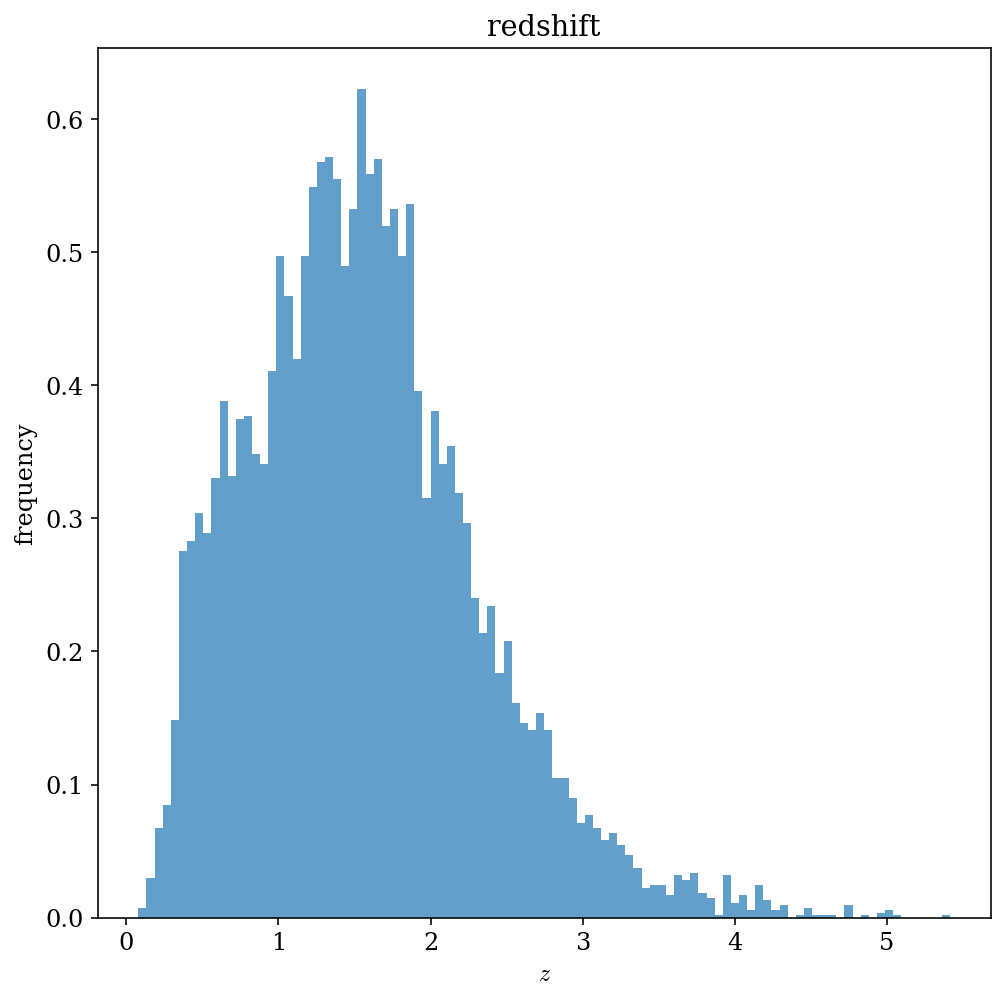

In [3]:
n, edges = np.histogram(z, bins = 100, density =True)
hist_z = scipy.stats.rv_histogram((n, edges))

plt.hist(z, bins = 100, density = True, alpha = 0.7)
plt.xlabel("$z$")
plt.ylabel("frequency")
plt.title('redshift')
plt.show()

# Rejection sampling

In [4]:
N_samples = int(1e4) #number of samples

In [5]:
#scipy method
cloned_data_scipy = hist_z.rvs(size = N_samples)

In [6]:
#explicit method
z_samples = np.random.uniform(0, edges.max(), N_samples)
n_samples = np.random.uniform(0, n.max(), N_samples)

mask = n_samples <= hist_z.pdf(z_samples)
cloned_data_rej = z_samples[mask]

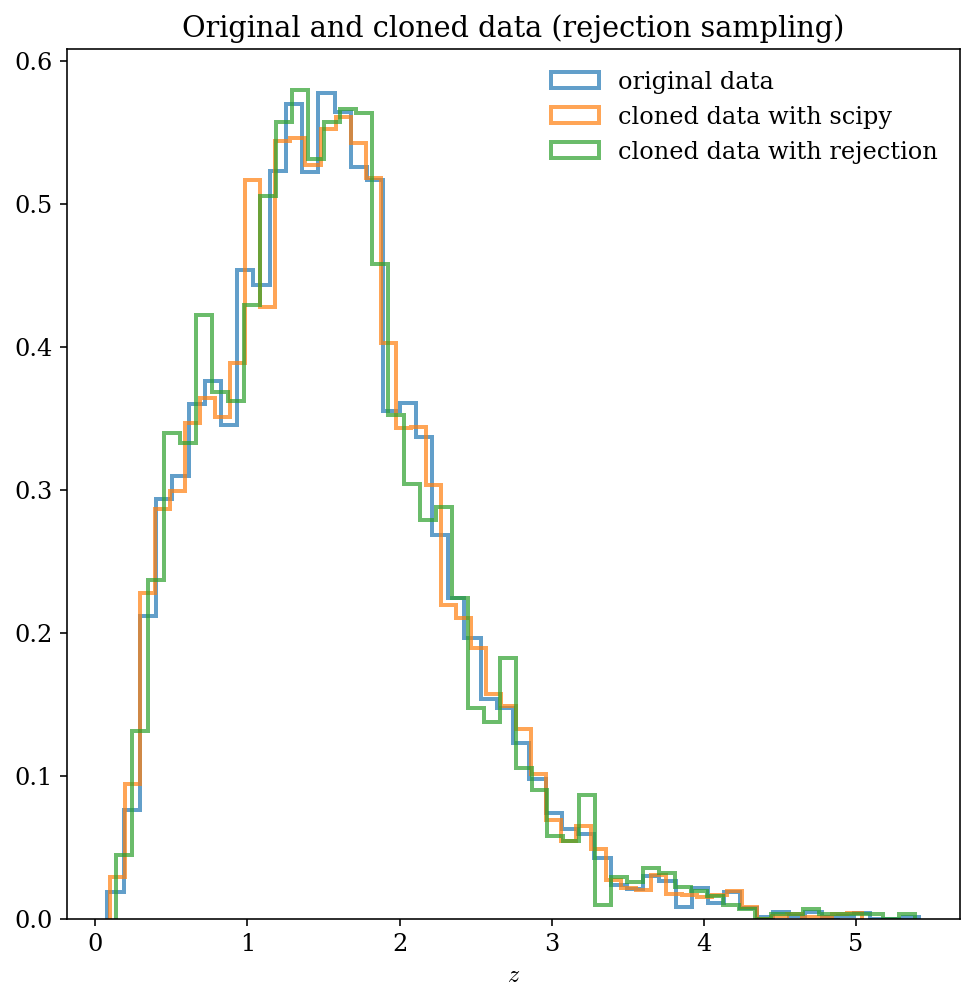

In [7]:
plt.hist(z, bins = 50, density = True, histtype = 'step', lw = 2, alpha = 0.7, label = 'original data')
plt.hist(cloned_data_scipy, bins = 50, density = True, histtype = 'step', lw = 2, alpha = 0.7, label = 'cloned data with scipy')
plt.hist(cloned_data_rej, bins = 50, density = True, histtype = 'step', lw = 2, alpha = 0.7, label = 'cloned data with rejection')
plt.xlabel("$z$")
plt.title('Original and cloned data (rejection sampling)')
plt.legend(frameon = False)
plt.show()

# Inverse transformation

In [8]:
centers = (edges[1:] + edges[:-1]) / 2 #centers of the bins
cdf_sum = np.cumsum(n) / np.sum(n) #estimate of the cumulative sum

cdf = scipy.interpolate.interp1d(centers, cdf_sum) #cdf
cdf_inverse = scipy.interpolate.interp1d(cdf_sum, centers) #inverse of the cdf

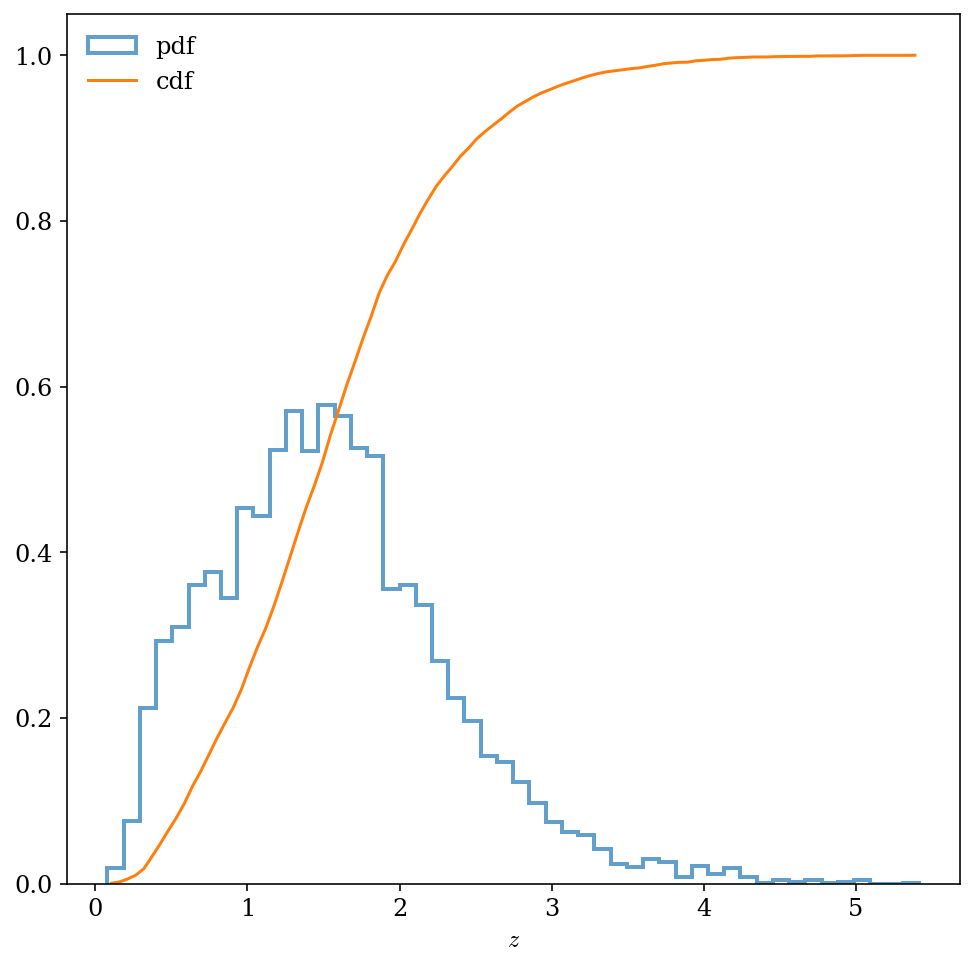

In [9]:
plt.hist(z, bins = 50, density = True, histtype = 'step', lw = 2, alpha = 0.7, label = 'pdf')
plt.plot(centers, cdf(centers), label = 'cdf')
plt.xlabel('$z$')
plt.legend(frameon = False)
plt.show()

In [10]:
#sampling
p_samples = np.random.uniform(cdf_sum.min(), min(1, cdf_sum.max()), N_samples) #extrema such that the interpolation range is not exceeded
z_samples = cdf_inverse(p_samples)

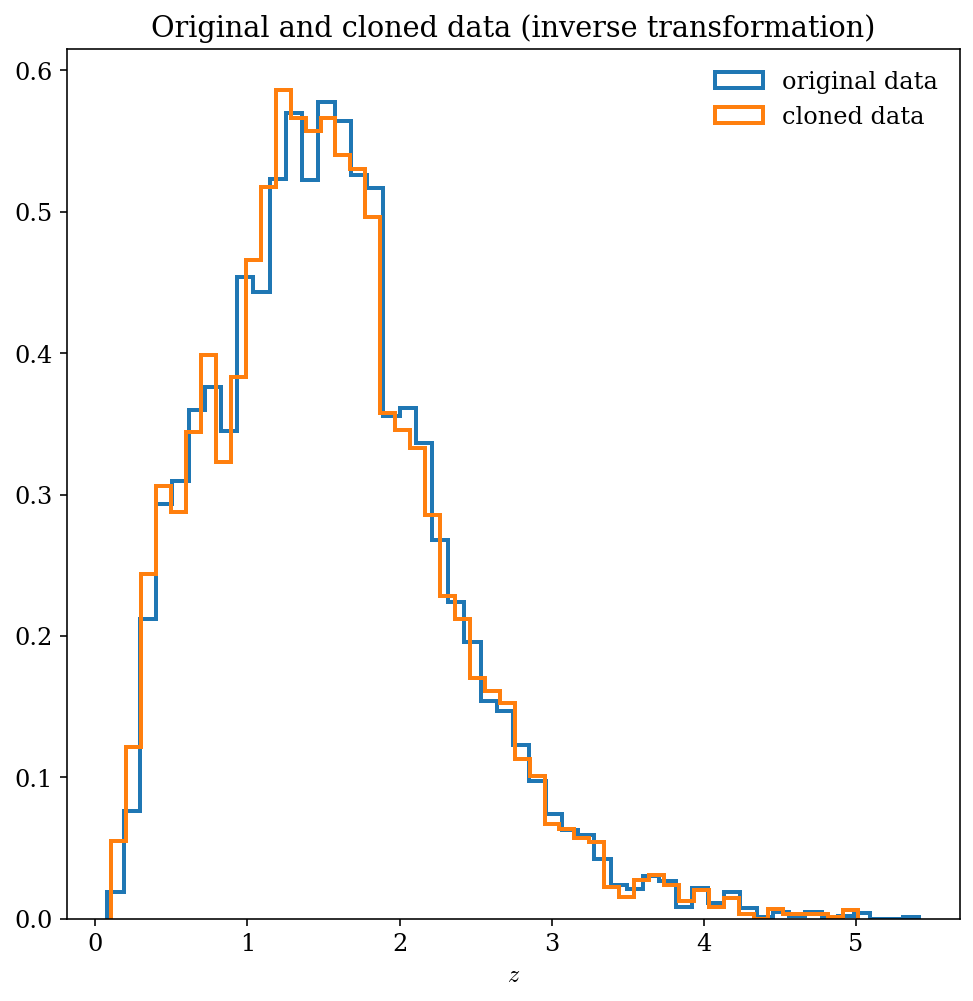

In [11]:
#plots
plt.hist(z, bins = 50, density = True, histtype = 'step', lw = 2,label = 'original data')
plt.hist(z_samples, bins = 50, density = True, histtype = 'step', lw = 2, label = 'cloned data')
plt.xlabel("$z$")
plt.title('Original and cloned data (inverse transformation)')
plt.legend(frameon = False)
plt.show()

## implement a quantitative check: KS test

In [12]:
from scipy.stats import ks_2samp

In [13]:
ks_scipy, p_scipy = ks_2samp(z, cloned_data_scipy) #resample with scipy
ks_rej, p_rej = ks_2samp(z, cloned_data_rej) #rejection sampling
ks_inverse, p_inverse = ks_2samp(z, z_samples) #inverse transform

In [14]:
methods = ['scipy', 'rejection sampling', 'inverse transform']
ks_stats = [ks_scipy, ks_rej, ks_inverse]
p_stats = [p_scipy, p_rej, p_inverse]
for method, ks, p in zip(methods, ks_stats, p_stats):
    print(method + ': ks = %.4f, p-value = %.4f' % (ks,p))

scipy: ks = 0.0071, p-value = 0.9626
rejection sampling: ks = 0.0145, p-value = 0.7162
inverse transform: ks = 0.0239, p-value = 0.0066


# cosmology  
are the quasars uniformly distributed?

In [15]:
from astropy.cosmology import Planck15
from scipy.integrate import quad

In [16]:
cosmo = Planck15

z.sort()

Vc = lambda z: cosmo.differential_comoving_volume(z).value * 4*np.pi #comoving volume
integral = quad(Vc, 0, max(z))[0]
Vc_z = Vc(z) / integral #normalize 

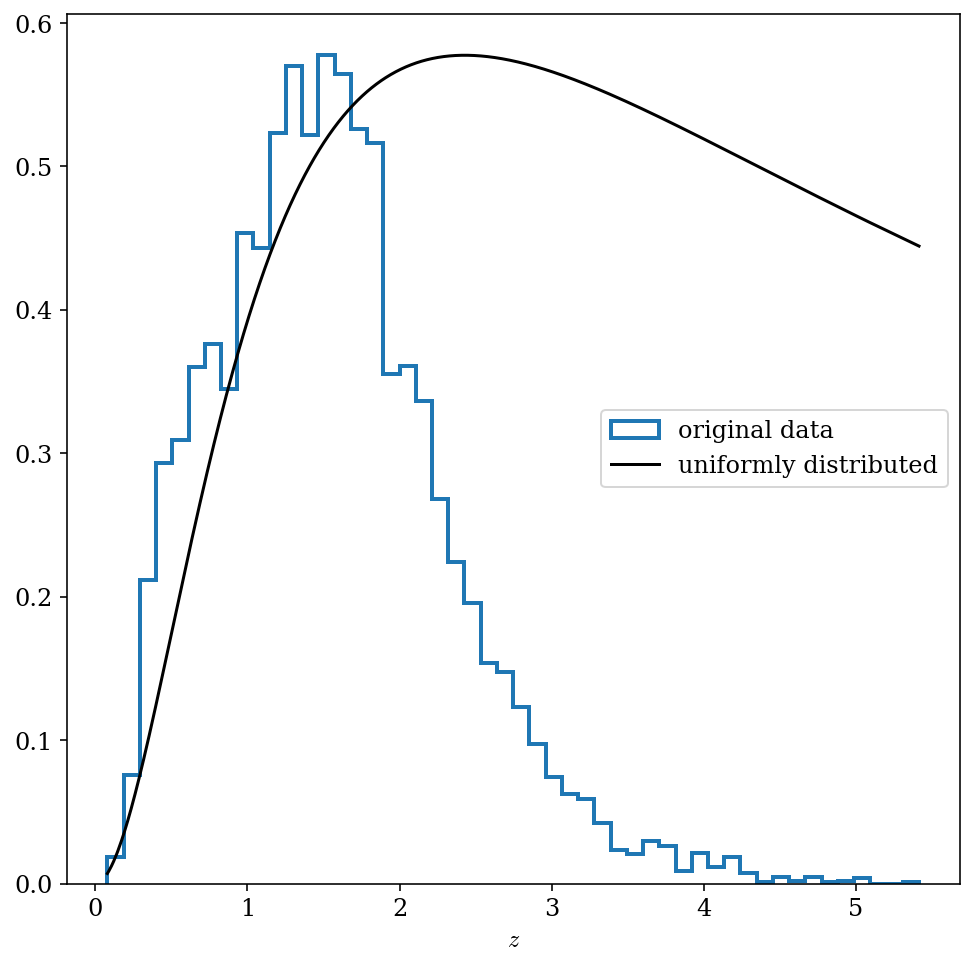

In [17]:
# plotting
H, _, _ = plt.hist(z, bins = 50, density = True, histtype = 'step', lw = 2, color='C0', label = 'original data')
plt.plot(z, max(H)/ max(Vc_z) * Vc_z, c = 'k', label='uniformly distributed')

plt.xlabel(r'$z$')
plt.legend(loc='center right')
plt.show()

**not uniformly distributed**

# extra

In [66]:
ra, dec = data['RA'], data['dec']

u, err_u = data['mag_u'], data['err_u']
g, err_g = data['mag_g'], data['err_g']
r, err_r = data['mag_r'], data['err_r']
i, err_i = data['mag_i'], data['err_i']
z, err_z = data['mag_z'], data['err_z']
J, err_J = data['mag_J'], data['err_J']
H, err_H = data['mag_H'], data['err_H']
K, err_K = data['mag_K'], data['err_K']

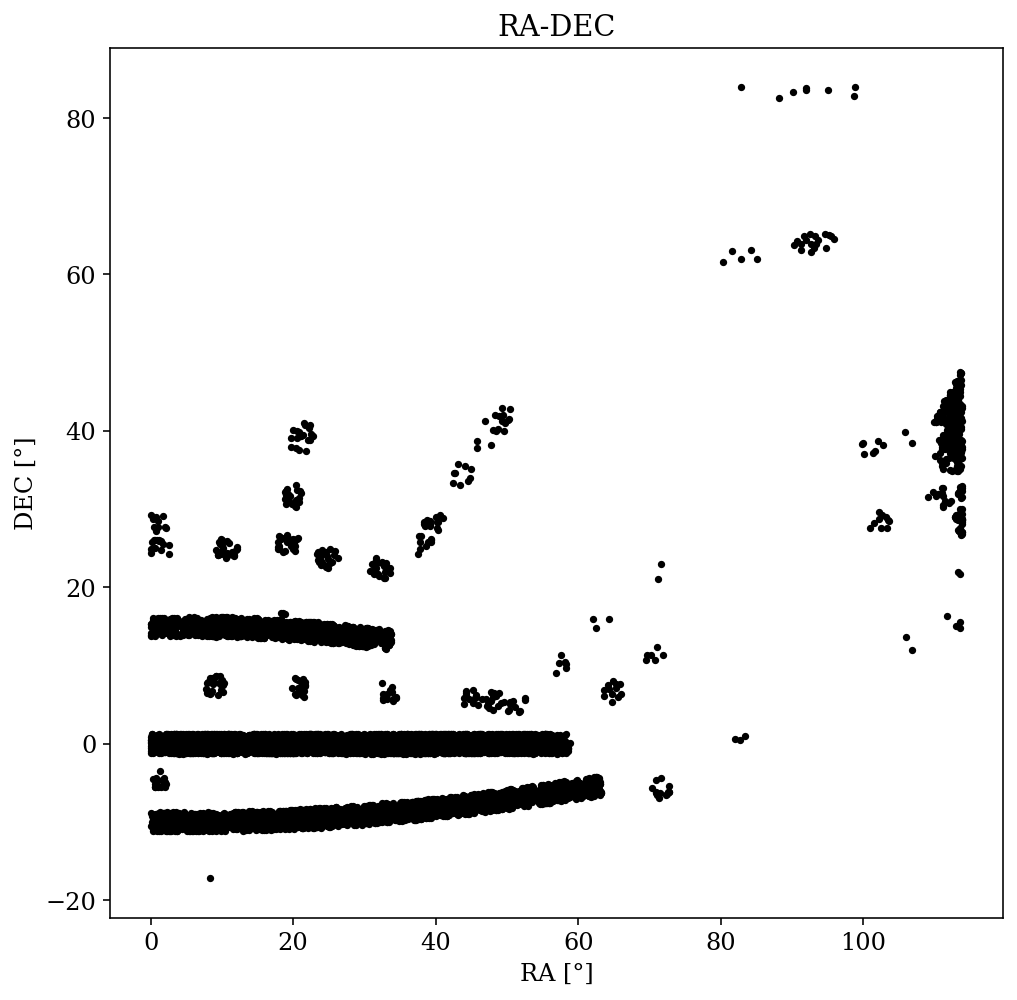

In [67]:
plt.scatter(ra,dec, c='k', s=7)

plt.xlabel('RA [°]')
plt.ylabel('DEC [°]')

plt.title('RA-DEC')
plt.show()

In [68]:
#pca?
from sklearn.decomposition import PCA

X = np.vstack((u,g,r,i,z,J,H,K)).T
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

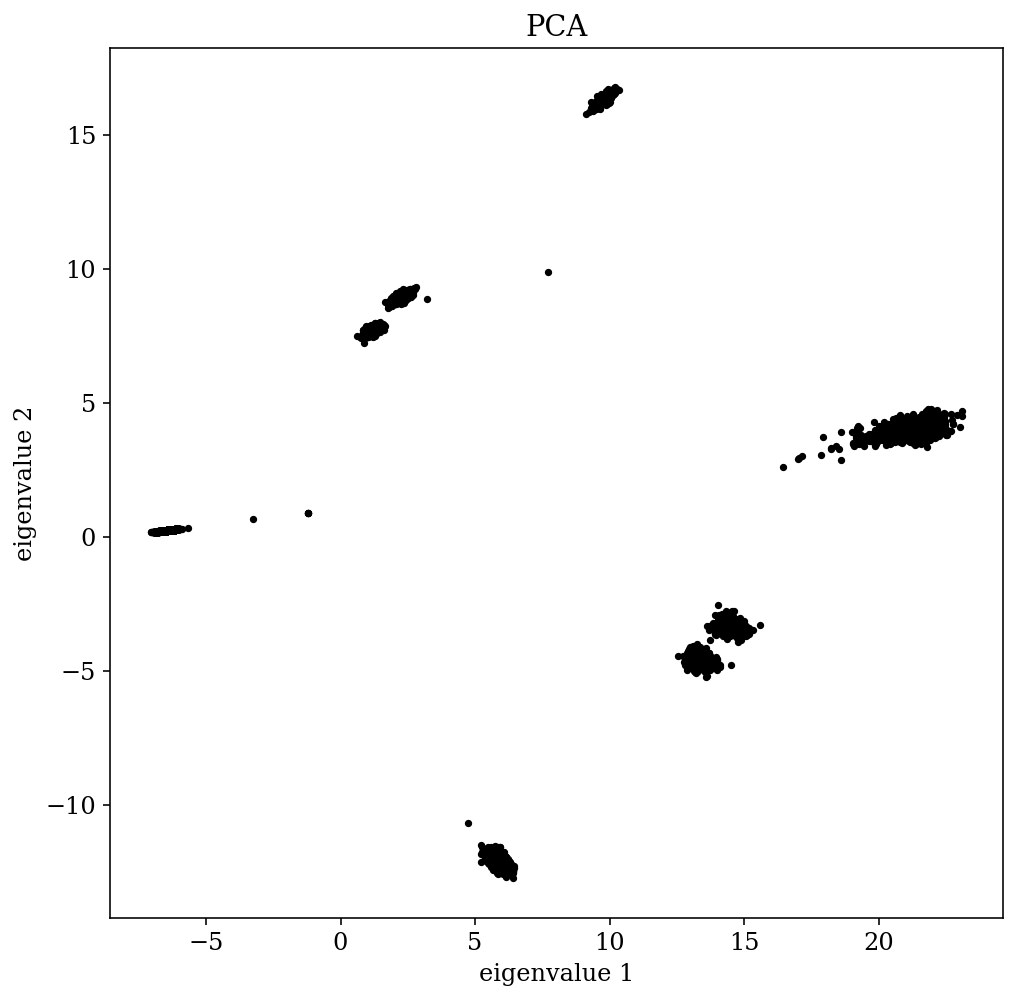

In [69]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c='k', s=7)

plt.xlabel('eigenvalue 1')
plt.ylabel('eigenvalue 2')

plt.title('PCA')
plt.show()

In [70]:
pca.explained_variance_ratio_

array([0.63794124, 0.19015446], dtype=float32)

In [71]:
pca_95 = PCA(n_components=0.95)
X_reduced_95 = pca_95.fit_transform(X)
print('%.i components are needed to explain 95 percent of the total variance' % len(X_reduced_95[0,:]))

3 components are needed to explain 95 percent of the total variance


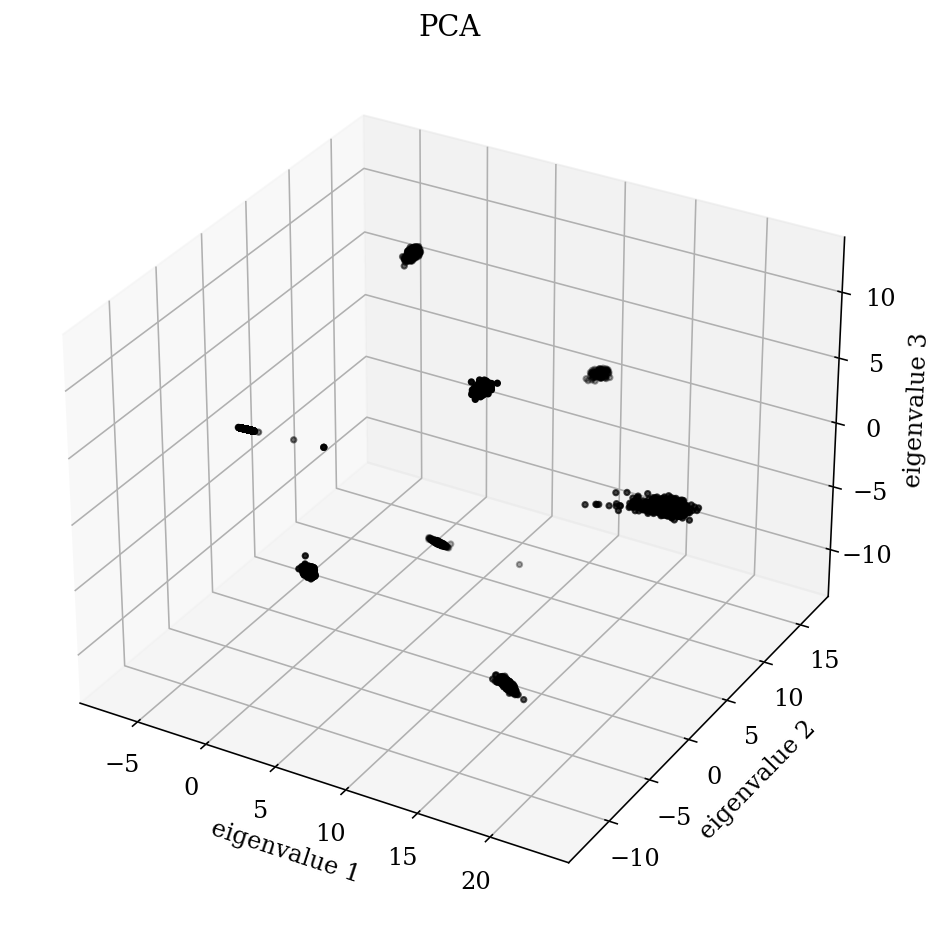

In [72]:
fig=plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_reduced_95[:,0], X_reduced_95[:,1], X_reduced_95[:,2], c='k', s=7)

ax.set_xlabel('eigenvalue 1')
ax.set_ylabel('eigenvalue 2')
ax.set_zlabel('eigenvalue 3')

ax.set_title('PCA')
plt.show()

8 clusters?

In [73]:
from sklearn.cluster import KMeans

In [74]:
n_comps = 8
clf = KMeans(n_clusters=n_comps)
clf.fit(X_reduced_95)

KMeans()

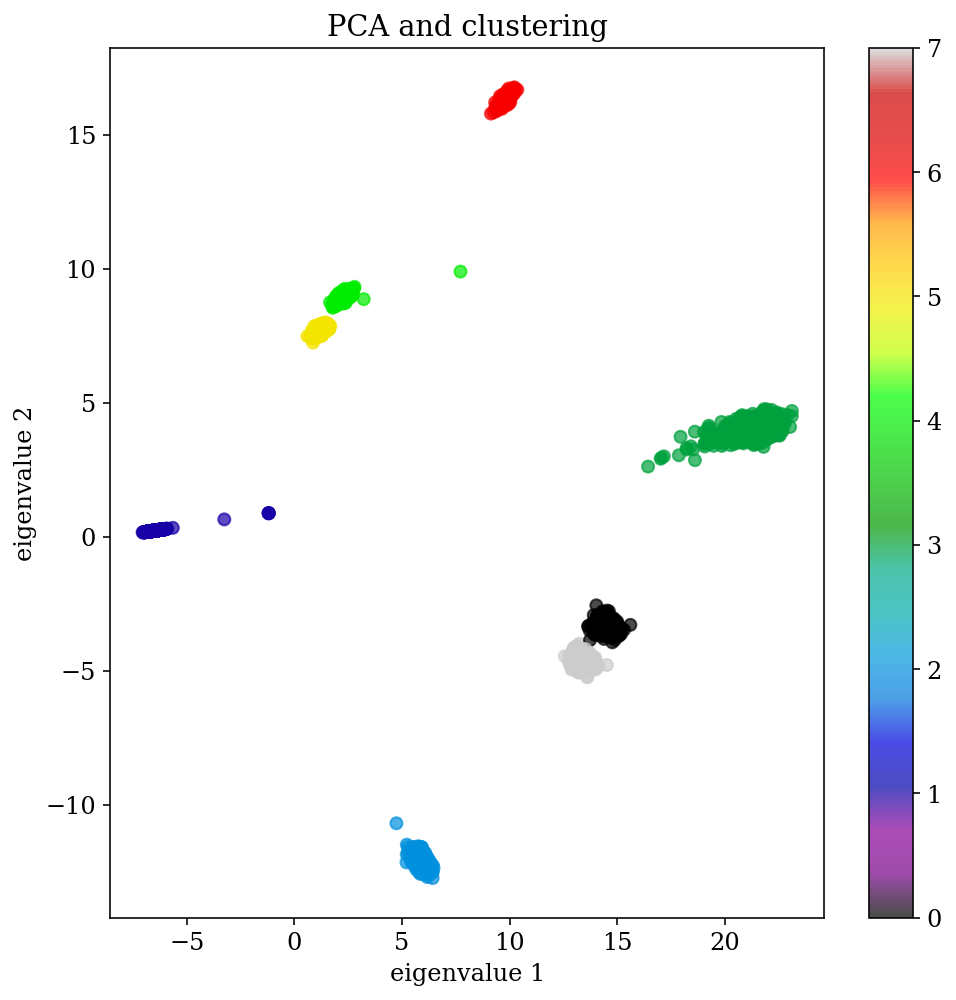

In [75]:
labels = clf.predict(X_reduced_95)
plt.scatter(X_reduced_95[:,0], X_reduced_95[:,1], c = labels, cmap='nipy_spectral', alpha = 0.7)
plt.colorbar()

plt.xlabel('eigenvalue 1')
plt.ylabel('eigenvalue 2')

plt.title('PCA and clustering')
plt.show()

KMeans has recognized all the clusters